Changes from v2

- implemented the possiblity to add nodes to the system
- add new visualization based data frame

**Importing Dependencies**

In [1]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
# Probably not needed --> test ray lib instead
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

from Environment.env_v4 import *
from Functions.visualization_functions import *

**Configuration of the Scenario**

In [2]:
# Configuration of the network
# Sample JSON configuration (replace this with your JSON data)
with open('./Config/network_config_v0.json') as file:
    network_config = file.read()

# TODO : Implement configuaration for cost and demand (actual and exptected)

**Building the environment**

In [17]:
EP_LENGTH = 30 # Length of the episode

env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 28}
Node C: {'type': 'manufacturer', 'I': 32}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


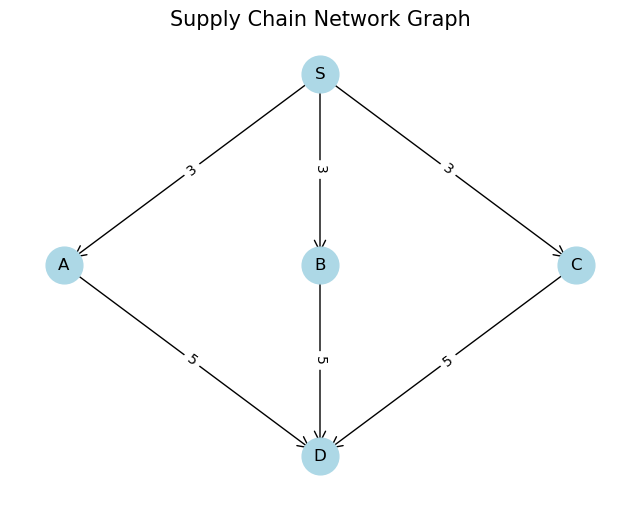

In [18]:
env.render_network()

In [4]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)

**Testng the environment**

In [5]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        # print('Step t:{} Score:{} Stock:{} Order:{} Delivered:{} Exp Demand t+3:{} Act Demand:{}'.format((EP_LENGTH - env.episode_length), score, n_state[0], action, env.delivered, n_state[1], env.demand))

        env.render()

    # print(env.order_history)

Episode Length: 1
Stock Level: [20.70661552 15.56674331 32.        ]
Planned Demand: [8.95059976 9.98251085 0.        ]
Actual Demand: [ 9.29338448 12.43325669  0.        ]
Action: [60.01768 91.5131  79.76227]
Order: [0, 0, 0]
Reward: -1224.7386908668063

Episode Length: 2
Stock Level: [ 3.82735638 15.56674331 32.        ]
Planned Demand: [11.40268794  0.          0.        ]
Actual Demand: [16.87925914  0.          0.        ]
Action: [57.45801  45.696102 23.790478]
Order: [0, 0, 0]
Reward: -1910.8557519844146

Episode Length: 3
Stock Level: [ 3.82735638 15.56674331 32.        ]
Planned Demand: [9.56451882 0.         0.        ]
Actual Demand: [22.46691886  0.          0.        ]
Action: [53.292973 31.15839  65.07445 ]
Order: [0, 0, 0]
Reward: -2719.87894103171

Episode Length: 4
Stock Level: [ 20.23320598  95.82699316 111.76226807]
Planned Demand: [8.74722575 7.198125   0.        ]
Actual Demand: [21.14491266 11.25284982  0.        ]
Action: [13.258698 31.911287 60.572357]
Order: [6

In [6]:
env.stock_history

[[30, 28, 32],
 [20.706615523606636, 15.566743311949757, 32.0],
 [3.827356379877255, 15.566743311949757, 32.0],
 [3.827356379877255, 15.566743311949757, 32.0],
 [20.233205984624853, 95.82699315854151, 111.76226806640625],
 [64.46013556663385, 141.5230953008755, 135.5527458190918],
 [117.75310813133112, 172.6814853460415, 200.62719345092773],
 [129.03484563047712, 204.59277265378077, 261.1995506286621],
 [186.64656285459822, 221.8187209948256, 261.7254096692643],
 [231.82066891381933, 226.2870456560805, 317.7695457166276],
 [265.0803457634379, 230.4835821970656, 350.26807914574135],
 [319.78286820170194, 263.4869467600539, 397.83694878571885],
 [375.887444229525, 253.66547958777957, 407.46747056001084],
 [430.49140344238316, 319.94535989020056, 435.0440508958204],
 [446.14353261566197, 373.19924325201697, 458.80380126203136],
 [514.8844460067753, 426.82588738653845, 511.5301463242872],
 [509.82513292151657, 439.5979496881742, 575.4659903996375],
 [598.3097596915361, 505.00074357245154, 

**Train Model**


In [10]:
log_path = os.path.join('Training', 'Logs')
model_path = os.path.join('Training', 'Models', 'PPO')

In [11]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

env = DummyVecEnv([lambda: env])

model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cpu device


In [12]:
model.learn(total_timesteps=10000)

Logging to Training/Logs/PPO_44
-----------------------------
| time/              |      |
|    fps             | 6142 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 3285          |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 3.3363758e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 7.31e+10      |
|    n_updates            | 10            |
|    policy_gradient_loss | -8.49e-05     |
|    std                  | 1             |
|    value

In [13]:
evaluate_policy(model, env, n_eval_episodes=1, render=True, return_episode_rewards=True)

Episode Length: 1
Stock Level: [21.79078148 16.41454889 19.62884467]
Planned Demand: [8.94254192 8.57521635 7.62685487]
Actual Demand: [ 8.20921852 11.58545111 12.37115533]
Action: [50.233536 49.724304 49.965347]
Order: [0, 0, 0]
Reward: -807.4500807970163

Episode Length: 2
Stock Level: [21.79078148 11.60759426 19.62884467]
Planned Demand: [0.         8.05896355 6.54271212]
Actual Demand: [0.         4.80695463 0.        ]
Action: [50.290615 49.644608 49.968212]
Order: [0, 0, 0]
Reward: -1609.9945131176562

Episode Length: 3
Stock Level: [21.79078148 11.60759426 19.62884467]
Planned Demand: [0. 0. 0.]
Actual Demand: [0. 0. 0.]
Action: [50.26187  49.645653 49.983795]
Order: [0, 0, 0]
Reward: -2412.4783375281404

Episode Length: 4
Stock Level: [56.19082646 51.87542149 64.60565625]
Planned Demand: [12.56716531  9.33379346  6.19935972]
Actual Demand: [15.83349079  9.45647697  4.98853571]
Action: [50.26187  49.645653 49.983795]
Order: [50.233536, 49.724304, 49.965347]
Reward: -3334.6068457

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


([-860424.7241210938], [30])

In [14]:
df = pd.read_csv('./Data/2024-10-14_18_last_environment_data.csv')

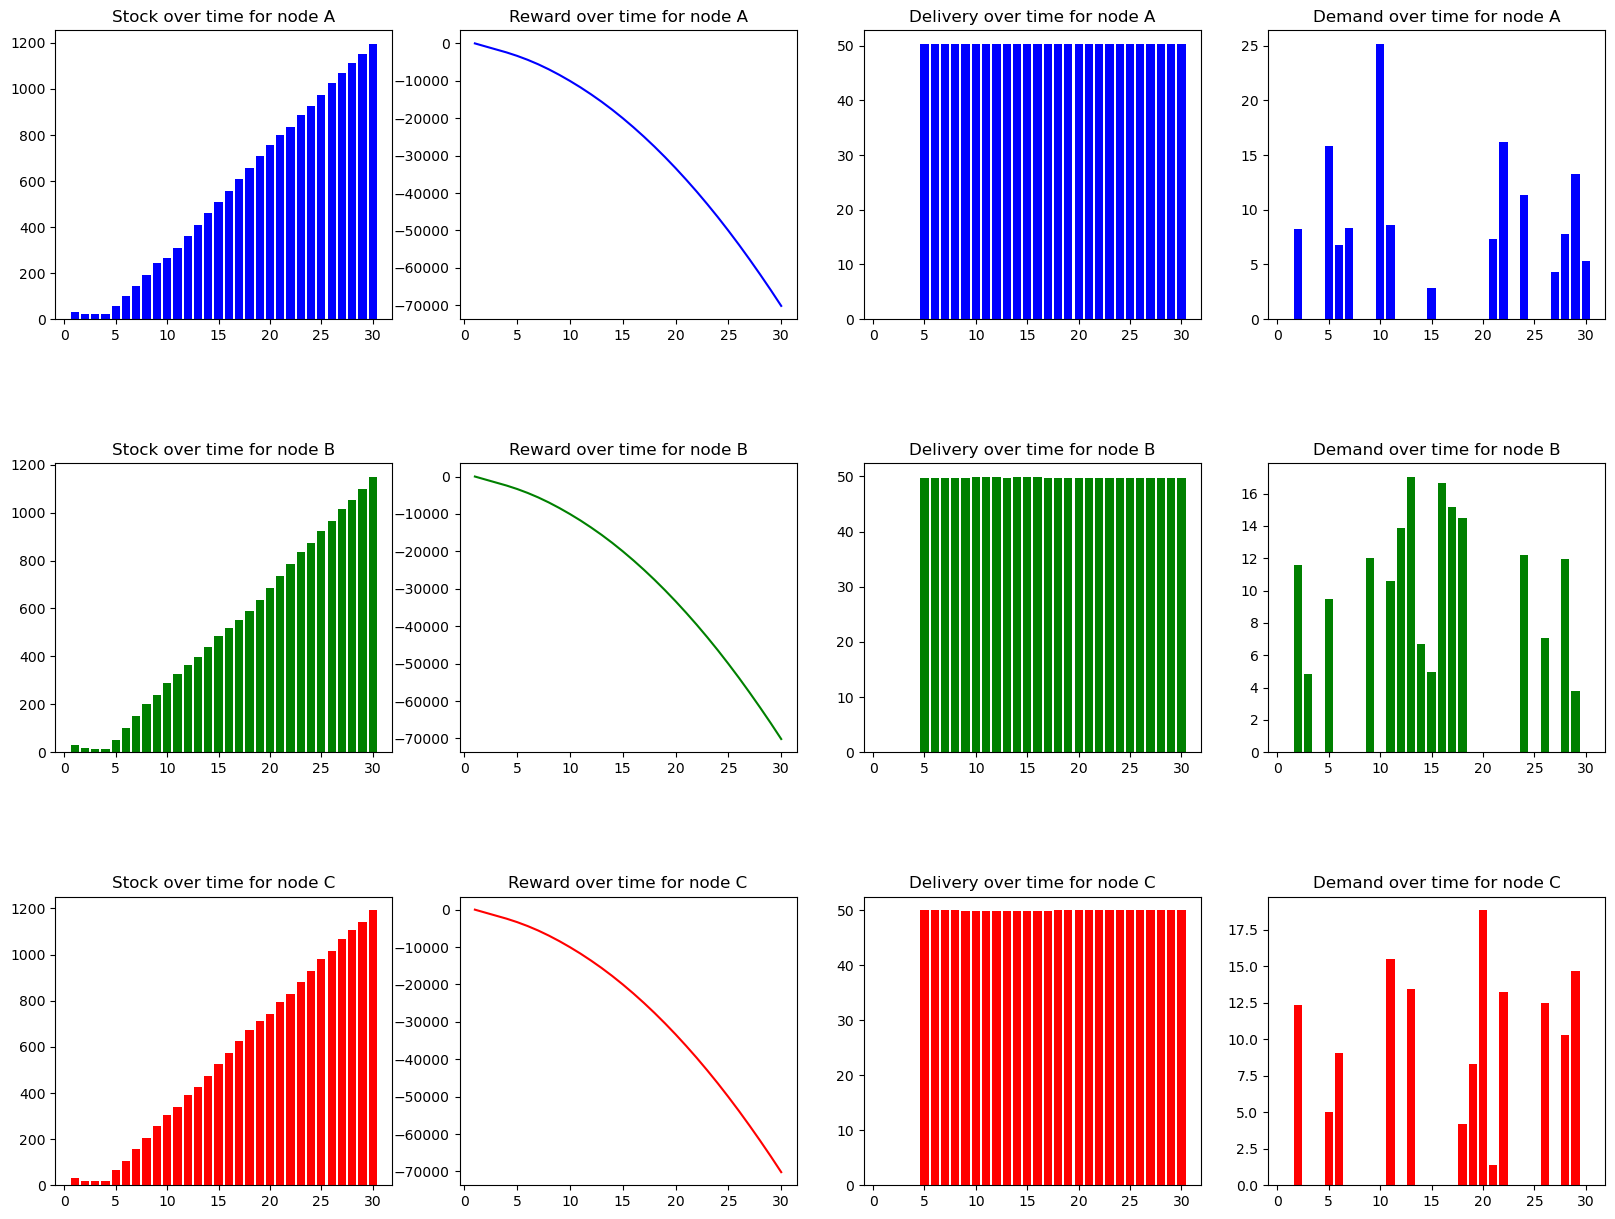

In [15]:
plot_data(df)